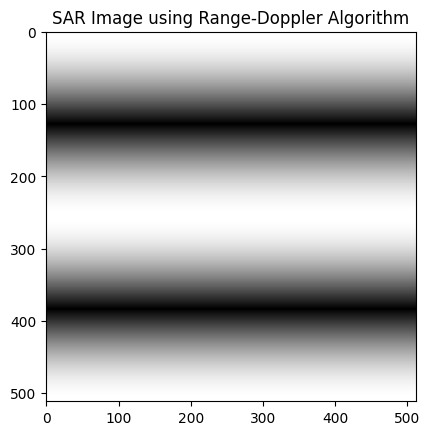

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Define parameters
c = 3e8  # Speed of light (m/s)
wavelength = 0.03  # Radar wavelength (meters)
PRF = 1000  # Pulse Repetition Frequency
velocity = 100  # Antenna velocity (m/s)
num_pulses = 512  # Number of pulses
num_samples = 512  # Number of range samples

# Simulate SAR raw data
targets = [(300, 0), (400, 200)]  # (Range, Azimuth) coordinates
raw_data = np.zeros((num_pulses, num_samples), dtype=complex)

for t in targets:
    range_idx = int(t[0] / (c / PRF))
    azimuth_idx = int(t[1] / velocity)
    raw_data[azimuth_idx, range_idx] = 1

# Apply 1D FFT in range dimension
range_fft = np.fft.fft(raw_data, axis=1)

# Apply FFT in azimuth dimension
sar_image = np.fft.fftshift(np.fft.fft(range_fft, axis=0))

# Display the SAR image
plt.imshow(np.abs(sar_image), cmap='gray')
plt.title('SAR Image using Range-Doppler Algorithm')
plt.show()


SAR Metadata:
Image Dimensions: 9415 x 9577 pixels
Azimuth Resolution: 0.500610267258809 meters
Range Resolution: 0.5006056911798499 meters


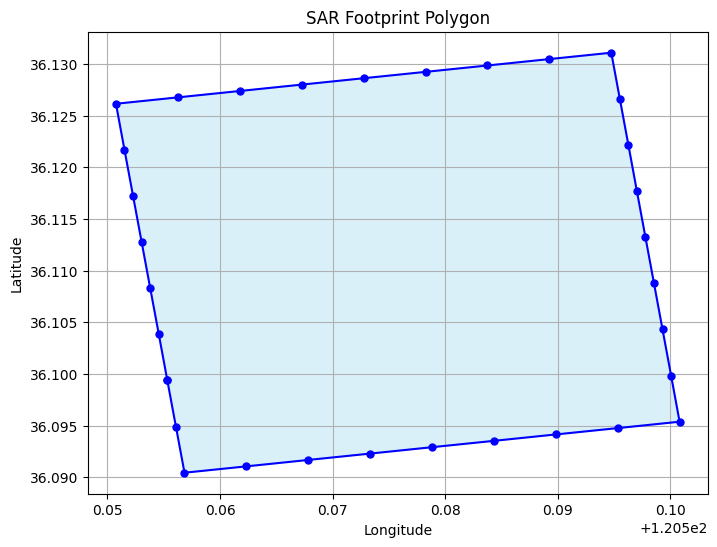

In [3]:
import json
import matplotlib.pyplot as plt

# Function to load the JSON data from a file
def load_sar_json(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data

# Function to extract and print SAR metadata
def print_sar_metadata(sar_data):
    sicd = sar_data["derivedProducts"]["SICD"][0]
    num_rows = sicd["numRows"]
    num_columns = sicd["numColumns"]
    azimuth_res = sicd["groundResolution"]["azimuthMeters"]
    range_res = sicd["groundResolution"]["rangeMeters"]
    
    print("SAR Metadata:")
    print(f"Image Dimensions: {num_rows} x {num_columns} pixels")
    print(f"Azimuth Resolution: {azimuth_res} meters")
    print(f"Range Resolution: {range_res} meters")

# Function to plot the SAR footprint polygon
def plot_footprint_polygon(sar_data):
    collect = sar_data["collects"][0]
    polygon = collect["footprintPolygonLla"]["coordinates"][0]

    # Extract latitude and longitude from the polygon
    lats = [point[1] for point in polygon]
    lons = [point[0] for point in polygon]

    # Plot the footprint polygon
    plt.figure(figsize=(8, 6))
    plt.plot(lons, lats, marker='o', linestyle='-', color='b', markersize=5)
    plt.fill(lons, lats, alpha=0.3, color='skyblue')
    plt.title("SAR Footprint Polygon")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.grid(True)
    plt.show()

# Main function
def main(file_path):
    sar_data = load_sar_json(file_path)
    print_sar_metadata(sar_data)
    plot_footprint_polygon(sar_data)

# Run the

if __name__ == "__main__":
    json_file_path = "umbra.json"  # Update this path
    main(json_file_path)

In [15]:
pip install tiledb

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.

  Obtaining dependency information for tiledb from https://files.pythonhosted.org/packages/dd/8f/6f100fcac5e38f6d41deff23669407f6b13ec01a6de32c4a12060ae9b139/tiledb-0.32.3-cp312-cp312-win_amd64.whl.metadata
   ---------------------------------------- 0.0/9.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.0 MB 653.6 kB/s eta 0:00:14
   - -------------------------------------- 0.3/9.0 MB 2.3 MB/s eta 0:00:04
   ---- ----------------------------------- 1.0/9.0 MB 7.3 MB/s eta 0:00:02
   --------- ------------------------------ 2.1/9.0 MB 12.1 MB/s eta 0:00:01
   -------------- ------------------------- 3.1/9.0 MB 14.3 MB/s eta 0:00:01
   ------------------ --------------------- 4.2/9.0 MB 15.7 MB/s eta 0:00:01
   ----------------------- ---------------- 5.2/9.


[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: C:\Users\Benjak617\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [16]:
import boto3
import botocore
import tiledb
import os
import matplotlib.pyplot as plt

# Set up S3 client with anonymous access
def get_s3_client():
    session = boto3.Session()
    s3 = session.client(
        's3',
        config=botocore.config.Config(signature_version=botocore.UNSIGNED)
    )
    return s3

# Download a specific TileDB file from S3
def download_tiledb_fragment(bucket_name, s3_key, local_path):
    s3 = get_s3_client()
    print(f"Downloading {s3_key} from {bucket_name}...")
    s3.download_file(bucket_name, s3_key, local_path)
    print(f"Downloaded to {local_path}.")

# List files in a specified S3 bucket prefix
def list_files_in_bucket(bucket_name, prefix=''):
    s3 = get_s3_client()
    response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)

    if 'Contents' in response:
        print("Files found:")
        for obj in response['Contents']:
            print(obj['Key'])
    else:
        print(f"No objects found in {bucket_name} with prefix '{prefix}'.")

# Load and display TileDB data
def visualize_tiledb_array(array_path):
    # Open the TileDB array
    with tiledb.open(array_path, "r") as array:
        print(f"Array schema: {array.schema}")
        data = array[:]

    # Display data using matplotlib (assuming 2D data)
    plt.figure(figsize=(10, 8))
    plt.imshow(data, cmap='gray')
    plt.title('SAR Image from TileDB Array')
    plt.colorbar(label='Amplitude')
    plt.show()

# Main function to list, download, and visualize TileDB data
def main():
    bucket_name = 'capella-open-data'
    prefix = 'data/tiledb/CAPELLA_C02_SM_GEC_HH_20201222051740_20201222051744/'

    # List files in the S3 bucket with the given prefix
    print("Listing files in the bucket...")
    list_files_in_bucket(bucket_name, prefix)

    # Download the TileDB fragment metadata
    s3_key = prefix + '__fragments/__1658347413194_1658347413194_75b4a6e6c97a4a6fa173cb7ca55cb9fb_13/a0.tdb'
    local_path = 'a0.tdb'
    download_tiledb_fragment(bucket_name, s3_key, local_path)

    # Visualize the TileDB array (assuming the downloaded file is a valid array)
    visualize_tiledb_array(local_path)

if __name__ == "__main__":
    main()



Listing files in the bucket...
Files found:
data/tiledb/CAPELLA_C02_SM_GEC_HH_20201222051740_20201222051744/__commits/__1658347413194_1658347413194_75b4a6e6c97a4a6fa173cb7ca55cb9fb_13.wrt
data/tiledb/CAPELLA_C02_SM_GEC_HH_20201222051740_20201222051744/__fragments/__1658347413194_1658347413194_75b4a6e6c97a4a6fa173cb7ca55cb9fb_13/__fragment_metadata.tdb
data/tiledb/CAPELLA_C02_SM_GEC_HH_20201222051740_20201222051744/__fragments/__1658347413194_1658347413194_75b4a6e6c97a4a6fa173cb7ca55cb9fb_13/a0.tdb
data/tiledb/CAPELLA_C02_SM_GEC_HH_20201222051740_20201222051744/__meta/__1658347408747_1658347408747_34cfae29dff9494eb80122998da57456
data/tiledb/CAPELLA_C02_SM_GEC_HH_20201222051740_20201222051744/__schema/__1658347408737_1658347408737_25c253be7cb2470f92f299bfb919b65e
Downloaded to a0.tdb.


TileDBError: [TileDB::Array] Error: Cannot open array; Array does not exist.

: 